In [1]:
pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install wmd
#pip install git+https://github.com/src-d/wmd-relax

In [1]:
# Libraries used on the tutorial
import boto3
import os
import time
import pandas as pd
import matplotlib as plt
from botocore.exceptions import ClientError
from datetime import date
import json
import seaborn as sns
import spacy
import numpy as np
#import wmd
from gensim.models import word2vec


%matplotlib inline

In [81]:
# Create a dictionary with the URLs for each speech on Youtube
dict_urls_youtube = {
    #'churchill': 'https://www.youtube.com/watch?v=s_LncVnecLA',
    'reagan': 'https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s',
    #'luther_king': 'https://www.youtube.com/watch?v=I47Y6VHc3Ms',
    #'macarthur': 'https://www.youtube.com/watch?v=_42_aLGkRpg&t=19s',
    'kennedy': 'https://www.youtube.com/watch?v=QAmHcdwKgtQ'}

In [82]:
# Download each speech in mp3 format using Youtube-DL
for url in list(dict_urls_youtube.values()):
    print(f'Downloading audio file from the link: {url}')
    os.system(f'youtube-dl -x --audio-format "mp3" {url}')

In [83]:
# Create a Dataframe to store the information trough the analysis
df_audio = pd.DataFrame.from_dict(dict_urls_youtube, orient='index', columns=['youtube_urls'])
df_audio

,youtube_urls
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ


In [84]:
# Linking the name of each audio file to the speaker
for audio_file in os.listdir('.'):
    #if 'churchill' in audio_file.lower():
    #    df_audio.at['churchill','filename'] = audio_file
    if 'reagan' in audio_file.lower():
        df_audio.at['reagan', 'filename'] = audio_file
   # elif 'king' in audio_file.lower():
   #     df_audio.at['luther_king', 'filename'] = audio_file
   # elif 'macarthur' in audio_file.lower():
   #    df_audio.at['macarthur', 'filename'] = audio_file
    elif 'kennedy' in audio_file.lower():
        df_audio.at['kennedy', 'filename'] = audio_file

In [85]:
df_audio

,youtube_urls,filename
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...


In [137]:
import boto3

aws_access_key_id = 'AKI***************************'
aws_secret_access_key = 'L*************************'
region_name = 'us-west-1'

session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key,
                                region_name=region_name)

In [170]:

# Uploading files to S3
# Instantiate client
s3 = boto3.client('s3')

# List created buckets
response = s3.list_buckets()
#print(response)
#buckets = [bucket['audiofirst'] for bucket in response['us-west-1']]
buckets = [bucket['Name'] for bucket in response['Buckets']]
for bucket in buckets:
    print(bucket)

audiofirst
bucket-audio1


In [187]:
# Creating a new S3 bucket to upload the audio files
bucket_name = 'audiofirst'
client_s3 = boto3.client('s3')
#do not use here
#client_s3.create_bucket(Bucket=bucket_name)
# this code is replaced as below in cmd
# aws s3 mb s3://bucket-audio1 --region us-west-1 --endpoint-url https://s3.us-west-1.amazonaws.com
#  make_bucket: bucket-audio1

In [108]:
# Uploading the files to the created bucket
for audio_file in df_audio.filename.values:
    print(audio_file)
    #client_s3.upload_file(audio_file, bucket_name,  audio_file)
    client_s3.upload_file(audio_file, 'audiofirst',  audio_file)

'Berlin Wall' Speech - President Reagan's Address at the Brandenburg Gate - 6_12_87-5MDFX-dNtsM.m4a
'We choose to go to the moon' Speech by President John F. Kennedy-QAmHcdwKgtQ.m4a


In [180]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://audiofirst.s3.amazonaws.com/'Berlin+Wa...,https://audiofirst.s3.amazonaws.com/reagan_spe...,reagan_speech_20032020.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://audiofirst.s3.amazonaws.com/'We+choose...,https://audiofirst.s3.amazonaws.com/kennedy_sp...,kennedy_speech_20032020.json


In [181]:

# Define the file URLs on the bucket using S3 convention for file paths
for index, row in df_audio.iterrows():
    bucket_location = boto3.client('s3').get_bucket_location(Bucket='audiofirst')
    object_url = f"https://{'audiofirst'}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df_audio.at[index, 'url'] = object_url
    print(object_url)

https://audiofirst.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.m4a
https://audiofirst.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.m4a


In [182]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://audiofirst.s3.amazonaws.com/'Berlin+Wa...,https://audiofirst.s3.amazonaws.com/reagan_spe...,reagan_speech_20032020.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://audiofirst.s3.amazonaws.com/'We+choose...,https://audiofirst.s3.amazonaws.com/kennedy_sp...,kennedy_speech_20032020.json


In [188]:

# Function to start Amazon Transcribe job
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = boto3.client('transcribe', region_name='us-west-1')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp4',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    if wait_process:
        while True:
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status
    
        

In [190]:
df_audio
df_audio.to_csv('C:/Users/woneu/Desktop/data1.csv', index = False)

In [218]:

# Define today's date to use on job name
today = date.today().strftime("%d%m%Y")

# Iterate over the audio files URLs on S3 and call start_transcription
# the name in start_ & df_audio.at should be the same
for index, row in df_audio.iterrows():    
    print(f'{index}_speech_{today}', row.url)
    start_transcription(bucket_name, f'{index}_speech_{today}_a', row.url, wait_process=False)
    #original
    #start_transcription(bucket_name, f'{index}_speech_{today}', row.url, wait_process=False)
    df_audio.at[index, 'transcription_url'] = f"https://{bucket_name}.s3.amazonaws.com/{index}_speech_{today}.json"
    df_audio.at[index, 'json_transcription'] = f"{index}_speech_{today}_a.json"

reagan_speech_20032020 https://audiofirst.s3.amazonaws.com/'Berlin+Wall'+Speech+-+President+Reagan's+Address+at+the+Brandenburg+Gate+-+6_12_87-5MDFX-dNtsM.m4a
kennedy_speech_20032020 https://audiofirst.s3.amazonaws.com/'We+choose+to+go+to+the+moon'+Speech+by+President+John+F.+Kennedy-QAmHcdwKgtQ.m4a


In [219]:
df_audio
#df_audio.to_csv('C:/Users/woneu/Desktop/data.csv', index = False)

,youtube_urls,filename,url,transcription_url,json_transcription
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://audiofirst.s3.amazonaws.com/'Berlin+Wa...,https://audiofirst.s3.amazonaws.com/reagan_spe...,reagan_speech_20032020_a.json
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://audiofirst.s3.amazonaws.com/'We+choose...,https://audiofirst.s3.amazonaws.com/kennedy_sp...,kennedy_speech_20032020_a.json


In [220]:
# Verify Amazon Transcrive jobs that are under the status COMPLETE
client_transcribe = boto3.client('transcribe', region_name='us-west-1')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
   
response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp90dXuFrGDwH9mu7LZ4J1RaiIpumT2vQoyWUUpbJXmD+zMmcF2goV35cRlwmhbomxjmf7CQblIr60XJbRTDEVQjW3mllfszOk/kVIGYBWVVKh5bGqmPWhpTsMlk9V7i0q+OSkWME/21vi4tOjK9wlUDv2AO7hvsdOqT5Bx1zL3LaJhlSVnaOaDr0UR6QdCP1P2ZJaz9a+gU3jkMOzIfY3Okm1xjo8X69x1qPtbrtocfBljLOcCddure6yB5KcXe5ro3FLxIEgh8VA9E1uxqAqwiz/QunSgpHA5+sUZ/NEm1sDjxGiS1K6u2LMLoGPcHtrzVbsJ4uEVxxdEbsaUUhQF4hPB0P5J5ojD9VjrQ1gF76kU880coX+lwX1CrfrgQfP830u7rc//gyrEDtbbWiAr8I/9sE9qJL1tCLDnzR7AA2rxf6QfLvwzn5q4H10Ap9Cta4bWtueD36rMePXz7btTCOL1qrzjPS70YmvVmhY68bKJzO5fPWodnUq7J2/2IysqdHYoG5cX5lyqHLk8i1Evuv99sYSyroE8fW9fS2pymuOlJTynG91Cz1393z9qMrIl6yOc0/Ld7la7pDbOtlSvWgMZpVyx1N6k9WW6NYgKdOgtmNwvPRYJrGJhOHH3f89ZCrXvLFk+HJ8120Q2ilt2eyiVTAWD2lO13ZpibjoKo5Sb8oAb2xyrFZBWa3E1Q69z9list1AoFVlG5xCQuolsP6UOQbNCQ0ruz9d4ZQepI7Nlyp0XmNDO+evlWx1Kr0lRlHVh03B/iSviIHul/QiapcPod0YrLsUpJg/N7cy8D7XlG557Bfbga1qiJNHZDG2U44xS83xGY0HFsYo89PtuhBVpUQtrxVAYlePY9Fdem8k9z/WXGZjIVG0=',
 'TranscriptionJobSummaries': [{'TranscriptionJobNam


Comparing the audio transcription with the original transcription using Spacy
In order to check the quality of the transcription generated using Amazon Transcribe we are going to compare it to the original text using the SpaCy library.

In [221]:
# Function to get text from the JSON file generated using Amazon Transcribe
def get_text_from_json(bucket, key):
    s3 = boto3.client('s3', region_name='us-west-1')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

In [222]:
# Reading the original transcription from the JSON file
with open('C:/Users/woneu/Desktop/original_transcripts.json', 'r', encoding="utf8") as f:
    original_transcriptions = json.load(f)
    #print(original_transcriptions)

In [223]:
def process_text(text):
    """
    Process text by removing stop words, punctuation,
    pronouns and performing lemmatization on tokens.
    
    Parameters
    text (str): Any given text
    
    Return
    str: Processed text
    """
    doc = nlp(text.lower())
    result = []
    for token in doc:
        if token.text in nlp.Defaults.stop_words:
            continue
        if token.is_punct:
            continue
        if token.lemma_ == '-PRON-':
            continue
        result.append(token.lemma_)
    return " ".join(result)

In [225]:
# Iterate over the speakers comparing the transcription texts using spaCy
# !!!!!run only after ckecking the upload of transcription json file on s3
for index, row in df_audio.iterrows():
    nlp = spacy.load('en_core_web_lg') # must download model first via `python3 -m spacy download en_core_web_lg`
    original_transcription = nlp(process_text(original_transcriptions.get(index)))
    print(row.json_transcription)
    transcribe_transcription = nlp(process_text(get_text_from_json(bucket_name, row.json_transcription)))
    w2v_similarity = original_transcription.similarity(transcribe_transcription)
    
    df_audio.at[index, 'w2v_text_similarity'] = w2v_similarity
    print(f'Word2vec Similarity for {index}\'s speech: {w2v_similarity}')
    

reagan_speech_20032020_a.json
Word2vec Similarity for reagan's speech: 0.9994752513721701
kennedy_speech_20032020_a.json
Word2vec Similarity for kennedy's speech: 0.9996413482224711


In [226]:
# Create columns with formated speaker name and word2vec similarity
y_labels = [label.replace('_', ' ').capitalize() for label in df_audio.index]
print(y_labels)
x_values = [x * 100 for x in df_audio.w2v_text_similarity ]
print(x_values)
df_audio['label_capitalized'], df_audio['similarity_perc'] = y_labels, x_values

['Reagan', 'Kennedy']
[99.94752513721701, 99.9641348222471]


In [227]:
df_audio

,youtube_urls,filename,url,transcription_url,json_transcription,w2v_text_similarity,label_capitalized,similarity_perc
reagan,https://www.youtube.com/watch?v=5MDFX-dNtsM&t=6s,'Berlin Wall' Speech - President Reagan's Addr...,https://audiofirst.s3.amazonaws.com/'Berlin+Wa...,https://audiofirst.s3.amazonaws.com/reagan_spe...,reagan_speech_20032020_a.json,0.999475,Reagan,99.947525
kennedy,https://www.youtube.com/watch?v=QAmHcdwKgtQ,'We choose to go to the moon' Speech by Presid...,https://audiofirst.s3.amazonaws.com/'We+choose...,https://audiofirst.s3.amazonaws.com/kennedy_sp...,kennedy_speech_20032020_a.json,0.999641,Kennedy,99.964135


In [228]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = f'{round(p.get_width(),2)}%'
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

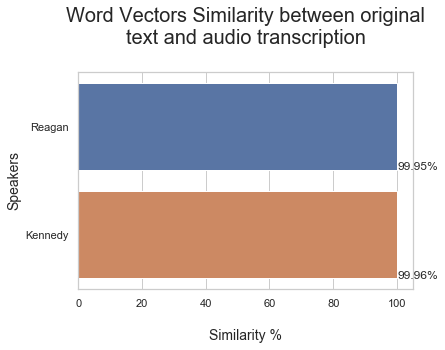

In [229]:
# Plotting the results for similarity between the original transcripts and Amazon Transcribe transcription
sns.set(style="whitegrid")
ax = sns.barplot(y='label_capitalized', x='similarity_perc', 
                 data=df_audio, orient='h')
ax.set_title('Word Vectors Similarity between original\ntext and audio transcription\n', fontsize=20)
ax.set_xlabel('\nSimilarity %', fontsize=14)
ax.set_ylabel('Speakers', fontsize=14)

show_values_on_bars(ax, "h", 0.3)
ax.figure.savefig("word2vec_similarity.png", dpi=400, bbox_inches='tight')